In [ ]:
<div style="background-color:gray; padding:15px; border-radius:10px; font-size:20px; color:white;">
    <h2 style="margin-bottom:10px;">xgb 모델 예측 목차</h2>
    <ol style="padding-left:20px;">
        <li>데이터 확인</li>
        <li>(시도 1) 수동 전처리 사용</li>
        <li>추세 및 주기성 확인 (주파수 분석)</li>
    </ol>
</div>

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
데이터 확인
</div>

In [ ]:
# 기본 패키지
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 머신러닝 패키지
import xgboost as xgb
from sklearn.model_selection import KFold
import optuna
import time
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error


# 그래프 한글 표시
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [ ]:
# 사용자 정의 평가지표 MAPE 함수 생성
def MAPE(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # 분모가 0인 경우
    if np.any(y_true == 0):
        raise ValueError("0이 존재해서 불가능")

    # MAPE 계산
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 1)<br><br>
군집별 EDA 결과에 기반한 순서인코딩<br>
결측치 0 처리
</div>

In [ ]:
# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday

# 결측치 처리
train['num_sold'] = train['num_sold'].fillna(0)

# ------------------------------------------------------------------ 라벨 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
train['country'] = train['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
train['store'] = train['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
train['product'] = train['product'].map(product_mapping)

# (월,화,수,목 = 0) (금 = 1) (토 = 2) (일 = 3)
weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
train['mapped_weekday'] = train['weekday'].map(weekday_mapping)

# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   # 2, 5, 4, 3월 = 1
    9: 2, 10: 2,              # 9, 10월      = 2
    6: 3, 7: 3, 8: 3,         # 6, 7, 8월    = 3
    1: 4, 11: 4,              # 1, 11월      = 4
    12: 5}                    # 12월         = 5
train['mapped_month'] = train['month'].map(month_mapping)   

# 연도별 배핑
year_mapping = {
    2011: 1, 2013: 1,                  # 2011년, 2013년 = 1
    2012: 2, 2014: 2,                  # 2012년, 2014년 = 2
    2010: 3, 2015: 3, 2016: 3}         # 2010년, 2015년, 2016년 = 3
train['mapped_year'] = train['year'].map(year_mapping)

# 타겟 추출
y_df = train['num_sold']
log_y_df = np.log1p(y_df)

# 필요없는 변수 삭제
train = train.drop(['num_sold', 'id', 'date', 'year', 'month', 'weekday'] , axis = 1)

# 데이터 확인
train.head()

,country,store,product,mapped_weekday,mapped_month,mapped_year
0,3,0,0,1,4,3
1,3,0,4,1,4,3
2,3,0,3,1,4,3
3,3,0,1,1,4,3
4,3,0,2,1,4,3


In [ ]:
# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 50
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')

[I 2025-01-24 19:53:24,465] A new study created in memory with name: no-name-4ffd1622-8b85-4535-ad46-3ab899096034
XGBoost 하이퍼파라미터 튜닝 중...:  12%|█████▊                                          | 6/50 [00:29<04:07,  5.61s/it][W 2025-01-24 19:53:54,878] Trial 6 failed with parameters: {'n_estimators': 399, 'learning_rate': 0.653969002091379, 'max_depth': 10, 'subsample': 0.8337647566716564, 'colsample_bytree': 0.5529709102425904, 'min_child_weight': 3, 'gamma': 6.0416598164784565, 'reg_alpha': 5.6091488993617595, 'reg_lambda': 7.526041924599426} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Temp\ipykernel_10204\1838609157.py", line 30, in objective
    xgb_model.fit(x_train, y_train)
  File "C:\Users\user\anaconda3\Lib\site-packages\xgboost\core

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 2)<br><br>
군집별 EDA 결과에 기반한 순서인코딩<br>
결측치 0 처리<br>
주기성이 있는 sin,cos 파생변수 추가
</div>

In [ ]:

train = pd.read_csv('train.csv')
train.head()

# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 365)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['year_sin'] = np.sin(2 * np.pi * train['year'] / 7)
train['year_cos'] = np.cos(2 * np.pi * train['year'] / 7)

train['group'] = (train['year'] - 2010) * 48 + train['month'] * 4 + train['day'] // 7

# 결측치 처리
train['num_sold'] = train['num_sold'].fillna(0)

# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
train['country'] = train['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
train['store'] = train['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
train['product'] = train['product'].map(product_mapping)


weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
train['mapped_weekday'] = train['weekday'].map(weekday_mapping)

# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   
    9: 2, 10: 2,              
    6: 3, 7: 3, 8: 3,         
    1: 4, 11: 4,              
    12: 5}                     
train['mapped_month'] = train['month'].map(month_mapping)   

# 연도별 배핑
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
train['mapped_year'] = train['year'].map(year_mapping)
'''

# 반응변수 추출
y_df = train['num_sold']
log_y_df = np.log1p(y_df)

# 필요없는 변수 삭제
train = train.drop(['num_sold', 'id', 'date'] , axis = 1)

# 데이터 확인
train.head()

,country,store,product,year,month,weekday,day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group,mapped_weekday,mapped_month
0,3,0,0,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
1,3,0,4,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
2,3,0,3,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
3,3,0,1,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
4,3,0,2,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4


In [ ]:
# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 50
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')

[I 2025-01-24 20:25:49,296] A new study created in memory with name: no-name-d801565a-947f-4b32-951e-4ac6dfabee86
XGBoost 하이퍼파라미터 튜닝 중...: 100%|███████████████████████████████████████████████| 50/50 [05:29<00:00,  6.59s/it]

최고의 MAPE값 0.13145362994723192 

최고의 하이퍼 파라미터 {'n_estimators': 757, 'learning_rate': 0.06412315981044295, 'max_depth': 9, 'subsample': 0.8684849404478191, 'colsample_bytree': 0.8900125991644868, 'min_child_weight': 10, 'gamma': 0.6040728038337957, 'reg_alpha': 0.12133745427308273, 'reg_lambda': 7.6751064623177365} 



<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 3)<br><br>
군집별 EDA 결과에 기반한 순서인코딩<br>
결측치 0 처리<br>
주기성이 있는 sin,cos 파생변수 추가<br>
year, month, weekday 그대로 넣고 학습
</div>

In [ ]:
# ---------------------------------------------year, month, weekday 그대로 넣고 학습 ---------------------------------------------------

# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 50
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')

[I 2025-01-24 20:31:38,359] A new study created in memory with name: no-name-5f90f144-af29-4207-90a3-973171991212
XGBoost 하이퍼파라미터 튜닝 중...: 100%|███████████████████████████████████████████████| 50/50 [07:30<00:00,  9.01s/it]

최고의 MAPE값 0.13010926745131102 

최고의 하이퍼 파라미터 {'n_estimators': 835, 'learning_rate': 0.06945289620317992, 'max_depth': 10, 'subsample': 0.8976739184327465, 'colsample_bytree': 0.9380242683737381, 'min_child_weight': 10, 'gamma': 0.276292006511761, 'reg_alpha': 9.162146954425516, 'reg_lambda': 8.296086782509244} 



<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 4)<br><br>
군집별 EDA 결과에 기반한 순서인코딩<br>
주기성이 있는 sin,cos 파생변수 추가<br>
year, month, weekday 그대로 넣고 학습<br>
결측치 존재하는 케이스 제외
</div>

In [ ]:

# =================================================================================================================================
# ==================================================== 결측치 제외한 데이터 프레임 ==================================================
# =================================================================================================================================


train = pd.read_csv('train.csv')
train = train.dropna()
train = train.reset_index()


# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 365)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['year_sin'] = np.sin(2 * np.pi * train['year'] / 7)
train['year_cos'] = np.cos(2 * np.pi * train['year'] / 7)

train['group'] = (train['year'] - 2010) * 48 + train['month'] * 4 + train['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
train['country'] = train['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
train['store'] = train['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
train['product'] = train['product'].map(product_mapping)

weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
train['mapped_weekday'] = train['weekday'].map(weekday_mapping)

# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   
    9: 2, 10: 2,              
    6: 3, 7: 3, 8: 3,         
    1: 4, 11: 4,             
    12: 5}                     
train['mapped_month'] = train['month'].map(month_mapping)   

# 연도별 배핑
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
train['mapped_year'] = train['year'].map(year_mapping)
'''

# 반응변수 추출
y_df = train['num_sold']
log_y_df = np.log1p(y_df)

# 필요없는 변수 삭제
train = train.drop(['num_sold', 'id', 'date'] , axis = 1)

# 데이터 확인
train.head()

,index,country,store,product,year,month,weekday,day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group,mapped_weekday,mapped_month
0,1,3,0,4,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
1,2,3,0,3,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
2,3,3,0,1,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
3,4,3,0,2,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
4,5,3,1,0,2010,1,4,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4


In [35]:
from sklearn.metrics import mean_absolute_percentage_error

# --------------------------------------------- 결측치 제외하고 학습  ---------------------------------------------------

# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 50
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')

[I 2025-01-25 11:42:44,240] A new study created in memory with name: no-name-24fe02b2-0939-464f-853d-1fec68f3ed0b
XGBoost 하이퍼파라미터 튜닝 중...:  68%|███████████████████████████████▉               | 34/50 [03:03<01:21,  5.11s/it][W 2025-01-25 11:45:51,442] Trial 34 failed with parameters: {'n_estimators': 780, 'learning_rate': 0.5836502453199157, 'max_depth': 9, 'subsample': 0.9973095577583949, 'colsample_bytree': 0.5756563133449244, 'min_child_weight': 8, 'gamma': 0.6475641703364912, 'reg_alpha': 9.382049591507764, 'reg_lambda': 1.4689172356783513} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Temp\ipykernel_9608\3946747138.py", line 29, in objective
    x_train, x_val = train.iloc[train_index], train.iloc[val_index]
                     ^^^^^^^^^

In [ ]:
best_params = xgb_study.best_params
best_params.update({
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror"})

final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(train, log_y_df)

y_pred_log = final_xgb_model.predict(train)
y_pred = np.exp(y_pred_log)

feature_importances = final_xgb_model.feature_importances_
features = train.columns
importance_df = pd.DataFrame({
    'Feature' : features,
    'Importance' : feature_importances}).sort_values(by = 'Importance', ascending = False)

print('변수 중요도')
print(importance_df)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 4)<br><br>
군집별 EDA 결과에 기반한 순서인코딩<br>
주기성이 있는 sin,cos 파생변수 추가<br>
year, month, weekday 그대로 넣고 학습<br>
결측치 존재하는 케이스 제외<br>
반년 주기 파생변수 추가
</div>

In [ ]:

# =================================================================================================================================
# ==================================================== 반년 주기 추가 데이터 프레임 ==================================================
# =================================================================================================================================


train = pd.read_csv('train.csv')
train = train.dropna()
train = train.reset_index()


# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 365)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['year_sin'] = np.sin(2 * np.pi * train['year'] / 7)
train['year_cos'] = np.cos(2 * np.pi * train['year'] / 7)
train['half_year_sin'] = np.sin(2 * np.pi * train['day'] / 182.5)
train['half_year_cos'] = np.cos(2 * np.pi * train['day'] / 182.5)
train['group'] = (train['year'] - 2010) * 48 + train['month'] * 4 + train['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
train['country'] = train['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
train['store'] = train['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
train['product'] = train['product'].map(product_mapping)

weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
train['mapped_weekday'] = train['weekday'].map(weekday_mapping)

month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   
    9: 2, 10: 2,              
    6: 3, 7: 3, 8: 3,         
    1: 4, 11: 4,             
    12: 5}                    
train['mapped_month'] = train['month'].map(month_mapping)   

# 연도별 배핑
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
train['mapped_year'] = train['year'].map(year_mapping)
'''

# 반응변수 추출
y_df = train['num_sold']
log_y_df = np.log1p(y_df)

# 필요없는 변수 삭제
train = train.drop(['num_sold', 'id', 'date'] , axis = 1)

# 데이터 확인
train.head()

,index,country,store,product,year,month,weekday,day,day_of_week,week_of_year,...,month_sin,month_cos,year_sin,year_cos,half_year_sin,half_year_cos,group,mapped_weekday,mapped_month,mapped_year
0,1,3,0,4,2010,1,4,1,4,53,...,0.5,0.866025,0.781831,0.62349,0.034422,0.999407,4,1,4,3
1,2,3,0,3,2010,1,4,1,4,53,...,0.5,0.866025,0.781831,0.62349,0.034422,0.999407,4,1,4,3
2,3,3,0,1,2010,1,4,1,4,53,...,0.5,0.866025,0.781831,0.62349,0.034422,0.999407,4,1,4,3
3,4,3,0,2,2010,1,4,1,4,53,...,0.5,0.866025,0.781831,0.62349,0.034422,0.999407,4,1,4,3
4,5,3,1,0,2010,1,4,1,4,53,...,0.5,0.866025,0.781831,0.62349,0.034422,0.999407,4,1,4,3


In [ ]:
# --------------------------------------------- 반년 주기 추가하고 학습  ---------------------------------------------------

# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 50
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')

[I 2025-01-25 09:48:06,007] A new study created in memory with name: no-name-70ff0698-f065-48a6-8437-339859180146
XGBoost 하이퍼파라미터 튜닝 중...:   0%|                                                        | 0/50 [00:00<?, ?it/s]C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2025-01-25 09:48:13,139] Trial 0 finished with value: 0.07550358254349607 and parameters: {'n_estimators': 936, 

최고의 MAPE값 0.04557479381061712 

최고의 하이퍼 파라미터 {'n_estimators': 483, 'learning_rate': 0.4070828754571607, 'max_depth': 11, 'subsample': 0.788162582050869, 'colsample_bytree': 0.7808790985869158, 'min_child_weight': 9, 'gamma': 0.011373767322021756, 'reg_alpha': 1.3420045872712598, 'reg_lambda': 0.789042825482067} 



변수 중요도
           Feature  Importance
1          country    0.681168
3          product    0.191800
2            store    0.106893
15        year_cos    0.004626
8      day_of_week    0.004200
20    mapped_month    0.002264
18           group    0.001641
5            month    0.001178
9     week_of_year    0.001144
12       month_sin    0.001131
4             year    0.001088
13       month_cos    0.000711
6          weekday    0.000519
21     mapped_year    0.000502
0            index    0.000447
14        year_sin    0.000392
7              day    0.000119
10         day_sin    0.000092
19  mapped_weekday    0.000066
11         day_cos    0.000021
16   half_year_sin    0.000000
17   half_year_cos    0.000000


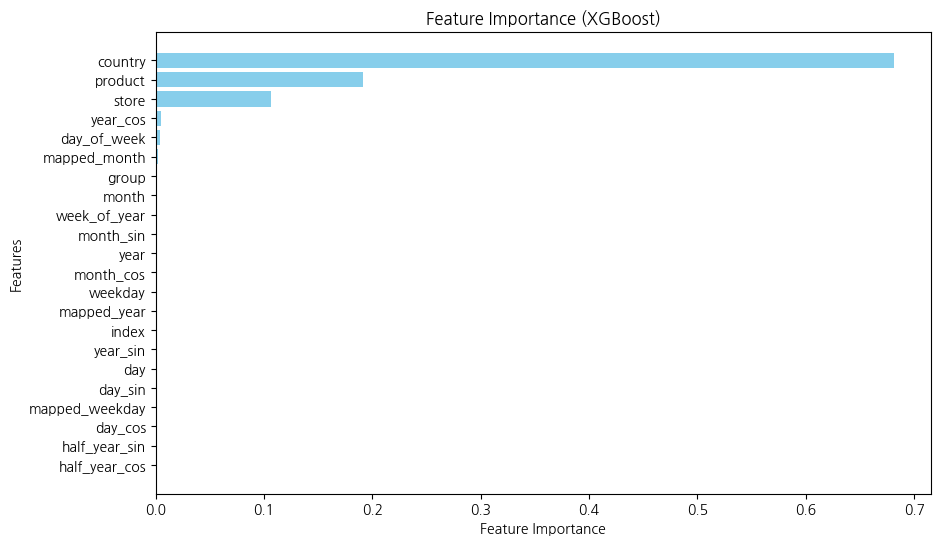

In [11]:
best_params = xgb_study.best_params
best_params.update({
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror"})

final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(train, log_y_df)

y_pred_log = final_xgb_model.predict(train)
y_pred = np.exp(y_pred_log)

feature_importances = final_xgb_model.feature_importances_
features = train.columns
importance_df = pd.DataFrame({
    'Feature' : features,
    'Importance' : feature_importances}).sort_values(by = 'Importance', ascending = False)

print('변수 중요도')
print(importance_df)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 5)<br><br>
군집별 EDA 결과에 기반한 순서인코딩<br>
주기성이 있는 sin,cos 파생변수 추가<br>
year, month, weekday 그대로 넣고 학습<br>
결측치 존재하는 케이스 제외<br>
반년 주기 파생변수 추가<br>
중복 변수 삭제 및 변수 추가
</div>



In [ ]:



train = pd.read_csv('train.csv')
train = train.dropna()
train = train.reset_index()


# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 365)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['year_sin'] = np.sin(2 * np.pi * train['year'] / 7)
train['year_cos'] = np.cos(2 * np.pi * train['year'] / 7)
train['group'] = (train['year'] - 2010) * 48 + train['month'] * 4 + train['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
train['country'] = train['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
train['store'] = train['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
train['product'] = train['product'].map(product_mapping)


weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
train['mapped_weekday'] = train['weekday'].map(weekday_mapping)

# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   
    9: 2, 10: 2,              
    6: 3, 7: 3, 8: 3,         
    1: 4, 11: 4,              
    12: 5}                     
train['mapped_month'] = train['month'].map(month_mapping)   

# 연도별 배핑
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
train['mapped_year'] = train['year'].map(year_mapping)
'''

# 반응변수 추출
y_df = train['num_sold']
log_y_df = np.log1p(y_df)

# 필요없는 변수 삭제
train = train.drop(['num_sold', 'id', 'date', 'index', 'day_of_week'] , axis = 1)

# 데이터 확인
train.head()

,country,store,product,year,month,weekday,day,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group,mapped_weekday,mapped_month
0,3,0,4,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
1,3,0,3,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
2,3,0,1,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
3,3,0,2,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4
4,3,1,0,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4,1,4


In [37]:
from sklearn.metrics import mean_absolute_percentage_error

# --------------------------------------------- 중복변수 삭제 및 변수 추가  ---------------------------------------------------

# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 50
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')

[I 2025-01-25 11:47:16,706] A new study created in memory with name: no-name-4d0ccf22-87a1-4de9-88f9-dd1a7f19388b
XGBoost 하이퍼파라미터 튜닝 중...: 100%|███████████████████████████████████████████████| 50/50 [04:29<00:00,  5.39s/it]

최고의 MAPE값 0.043960694841799194 

최고의 하이퍼 파라미터 {'n_estimators': 463, 'learning_rate': 0.07986115420116802, 'max_depth': 10, 'subsample': 0.8802837273216751, 'colsample_bytree': 0.900167513749665, 'min_child_weight': 2, 'gamma': 0.0059702090121105614, 'reg_alpha': 3.312339261946142, 'reg_lambda': 7.033865824347269} 



변수 중요도
           Feature  Importance
0          country    0.701473
1            store    0.143670
2          product    0.140071
13        year_cos    0.003651
5          weekday    0.002068
16    mapped_month    0.001834
10       month_sin    0.001363
3             year    0.001180
4            month    0.001010
15  mapped_weekday    0.000870
11       month_cos    0.000797
7     week_of_year    0.000786
14           group    0.000742
12        year_sin    0.000342
8          day_sin    0.000079
6              day    0.000063
9          day_cos    0.000000


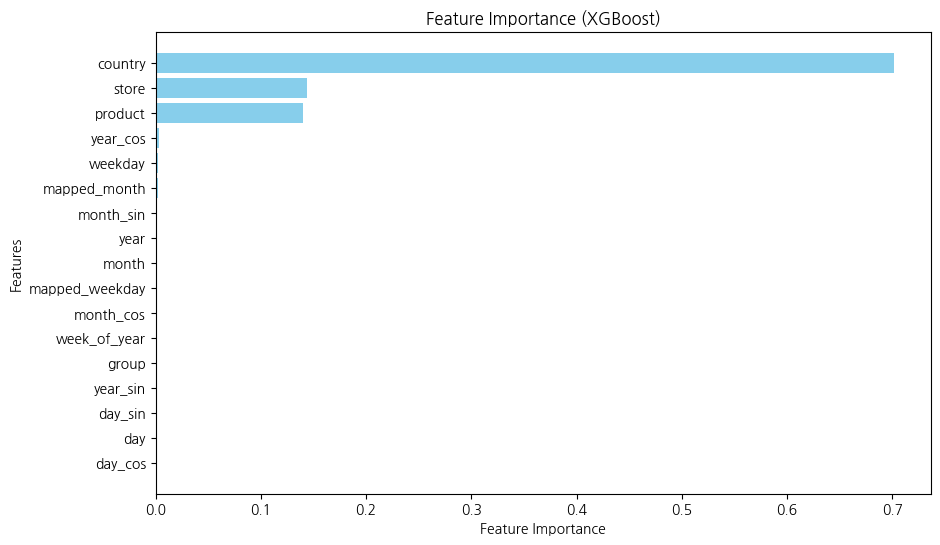

In [38]:
best_params = xgb_study.best_params
best_params.update({
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror"})

final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(train, log_y_df)

y_pred_log = final_xgb_model.predict(train)
y_pred = np.exp(y_pred_log)

feature_importances = final_xgb_model.feature_importances_
features = train.columns
importance_df = pd.DataFrame({
    'Feature' : features,
    'Importance' : feature_importances}).sort_values(by = 'Importance', ascending = False)

print('변수 중요도')
print(importance_df)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 6)<br><br>
군집별 EDA 결과에 기반한 순서인코딩<br>
주기성이 있는 sin,cos 파생변수 추가<br>
year, month, weekday 그대로 넣고 학습<br>
결측치 존재하는 케이스 제외<br>
반년 주기 파생변수 추가<br>
중복 변수 삭제 및 변수 추가<br>
하이퍼 파라미터 탐색공간 확장
</div>

In [39]:
from sklearn.metrics import mean_absolute_percentage_error

# --------------------------------------------- 반년 주기 추가하고 학습  ---------------------------------------------------

# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 2000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 200
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')

[I 2025-01-25 11:51:48,526] A new study created in memory with name: no-name-24fa1339-0659-41b1-865f-e89a50abd7ee
XGBoost 하이퍼파라미터 튜닝 중...: 100%|█████████████████████████████████████████████| 200/200 [41:35<00:00, 12.48s/it]

최고의 MAPE값 0.04395348266902842 

최고의 하이퍼 파라미터 {'n_estimators': 1735, 'learning_rate': 0.047728162214790565, 'max_depth': 12, 'subsample': 0.9057125109216521, 'colsample_bytree': 0.8572251007434795, 'min_child_weight': 2, 'gamma': 0.002018000677611335, 'reg_alpha': 5.948268406387103, 'reg_lambda': 9.578684556863058} 



<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
시도 6의 결과로 학습 후 제출
</div>

시도 6 하이퍼 파라미터  

최고의 MAPE값 0.043960694841799194 

최고의 하이퍼 파라미터 {'n_estimators': 463, 'learning_rate': 0.07986115420116802, 'max_depth': 10, 'subsample': 0.8802837273216751, 'colsample_bytree': 0.900167513749665, 'min_child_weight': 2, 'gamma': 0.0059702090121105614, 'reg_alpha': 3.312339261946142, 'reg_lambda': 7.033865824347269}

In [42]:
test = pd.read_csv('test.csv')
test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [44]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,num_sold
0,230130,100
1,230131,100
2,230132,100
3,230133,100
4,230134,100


In [45]:
# 테스트 데이터 전처리

# 테스트 데이터 전처리

# =================================================================================================================================
# ==================================================== 테스트 데이터 전처리 (시도 4로 ) ==================================================
# =================================================================================================================================


# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['weekday'] = test['date'].dt.weekday
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek
test['week_of_year'] = test['date'].dt.isocalendar().week
test['day_sin'] = np.sin(2 * np.pi * test['day'] / 365)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 365)
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)
test['year_sin'] = np.sin(2 * np.pi * test['year'] / 7)
test['year_cos'] = np.cos(2 * np.pi * test['year'] / 7)
test['group'] = (test['year'] - 2010) * 48 + test['month'] * 4 + test['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
test['country'] = test['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
test['store'] = test['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
test['product'] = test['product'].map(product_mapping)

# (월,화,수,목 = 0) (금 = 1) (토 = 2) (일 = 3)
weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
test['mapped_weekday'] = test['weekday'].map(weekday_mapping)

# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   # 2, 5, 4, 3월 → 1
    9: 2, 10: 2,              # 9, 10월 → 2
    6: 3, 7: 3, 8: 3,         # 6, 7, 8월 → 3
    1: 4, 11: 4,              # 1, 11월 → 4
    12: 5}                     # 12월 → 5
test['mapped_month'] = test['month'].map(month_mapping)   

# 연도별 매핑 (2017년 부터인줄 몰랐어)............
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
test['mapped_year'] = test['year'].map(year_mapping)
'''


# 필요없는 변수 삭제
test = test.drop(['id', 'date', 'day_of_week'] , axis = 1)

# 데이터 확인
test.head()


,country,store,product,year,month,weekday,day,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group,mapped_weekday,mapped_month
0,3,0,0,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340,3,4
1,3,0,4,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340,3,4
2,3,0,3,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340,3,4
3,3,0,1,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340,3,4
4,3,0,2,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340,3,4


Feature Importances:
           Feature  Importance
0          country    0.681670
2          product    0.155700
1            store    0.146062
13        year_cos    0.003463
15  mapped_weekday    0.002696
16    mapped_month    0.002083
10       month_sin    0.001815
5          weekday    0.001674
3             year    0.001396
11       month_cos    0.000928
7     week_of_year    0.000723
14           group    0.000608
4            month    0.000508
12        year_sin    0.000380
9          day_cos    0.000174
6              day    0.000061
8          day_sin    0.000059


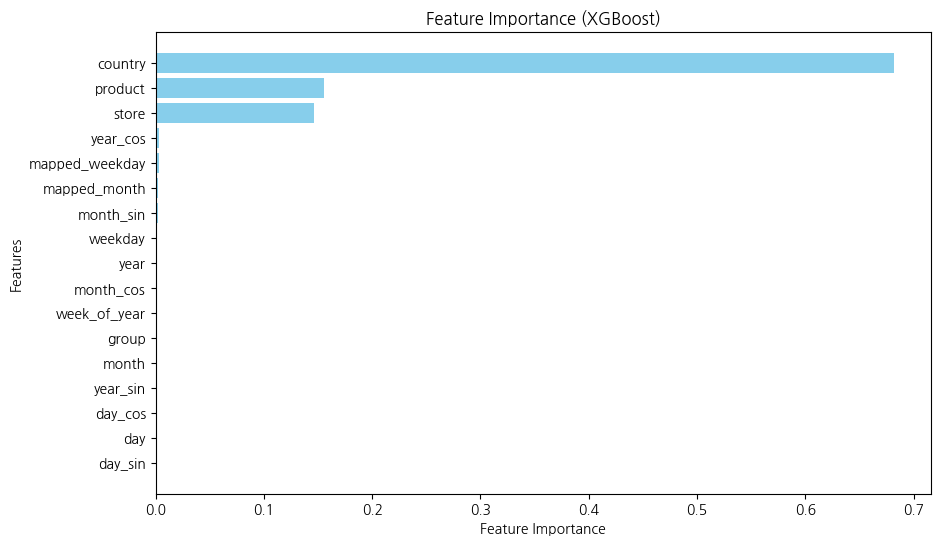

In [47]:
# 최적의 하이퍼파라미터 가져오기
best_params = {  
    'n_estimators': 463,
    'learning_rate': 0.07986115420116802,
    'max_depth': 10, 'subsample': 0.8802837273216751,
    'colsample_bytree': 0.900167513749665,
    'min_child_weight': 2,
    'gamma': 0.0059702090121105614,
    'reg_alpha': 3.312339261946142,
    'reg_lambda': 7.033865824347269,
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
} 

# 로그 변환된 타겟 값 사용
log_y_df = np.log(y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(train, log_y_df)

# 예측 및 지수 함수로 변환
y_pred_log = final_xgb_model.predict(test)
y_pred = np.exp(y_pred_log)  # 로그 변환된 값을 지수 함수로 복원

# 변수 중요도 추출
feature_importances = final_xgb_model.feature_importances_
features = train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

In [48]:
sub_6 = sub.copy()
sub_6['num_sold'] = y_pred

sub_6.to_csv('sub_6.csv', index = False)